# Online and Reinforcement Learning
## Instructor: Jeremy Eng
---
## Outline:
1. Online Learning
    - Offline vs Online Learning
    - Batch vs Stochastic Gradient Descent
    - SGD Examples
2. Reinforcement Learning
    - Introduction
    - Markov Decision Processes
    - Actions and Policies
    - Example
    - Q-Learning
3. Discussion

## Online Learning

### Offline vs Online Learning

- Most machine learning algorithms are "batch learners" (offline learning algorithms)
    - Generate a model by learning on the entire dataset **once**.
    - Training is done **before** deployment.
    - After deployment, there is no more learning.
    - Most well known and most used.
- There is another class of algorithms known as **online** learning algorithms.
    - Instead of learning on the entire dataset at once, data is consumed in sequential order as it becomes available.
    - Can be individual data or mini-batches
    - Each learning step is fast (new trained model is "updated", not completely re-trained)
    - Learning can be done after deployment (typically automated/scheduled).
    - E.g., COVID-19 modelling

#### Question: Offline (batch) or Online?
- YouTube video recommender
- House price predictor

---
### Batch vs Stochastic Gradient Descent

#### Quick Gradient Descent Review
- Iterative optimization algorithm (e.g. minimize loss function).
- Compute gradient (slope estimate), step in desired direction, update weights/model, and repeat.
- There are three types of gradient descent algorithms: batch, stochastic, and mini-batch.

<img src='images/GradientDescent.png'>

#### Batch Gradient Descent
- Computes gradient using all training data.

*Upsides:*
* Using all data points results in a more stable gradient and may result in a more stable convergence on some problems.
* The separation of the calculation of prediction errors and the model update lends the algorithm to parallel processing based implementations.
* Works well for convex or relatively smooth error manifolds.

*Downsides:*
* The more stable error gradient may result in premature convergence of the model to a less optimal set of parameters (local minima).
* Generally requires the entire training dataset in memory and available to the algorithm.
* Generally slower than stochastic gradient descent for very large training datasets.

#### Stochastic Gradient Descent
- Computes gradient using only a single data point. 

*Upsides:*
* Frequent model updates, which immediately give an insight into the performance of the model and the rate of improvement.
* The increased model update frequency can result in faster learning on some problems.
* The noisy update process can allow the model to avoid local minima (e.g. premature convergence).
* Generally faster than batch gradient descent for very large training datasets.

*Downsides:*
* The frequent updates can result in a noisy gradient signal, which may cause the model parameters and in turn the model error to jump around.
* The noisy learning process down the error gradient can also make it hard for the algorithm to settle on an error minimum for the model.

<img src='images/LocalMin.png'>

#### Mini-Batch Gradient Descent
- Splits the training dataset into small batches that are used to calculate the gradient.
- Implementations may choose to sum the gradient over the mini-batch which further reduces the variance of the gradient.
- Seeks to find a balance between the robustness of stochastic gradient descent and the efficiency of batch gradient descent.
- It is the most common implementation of gradient descent used in the field of deep learning.

<img src='images/descent.PNG'>

### Online Learning Example

Code and Demo from the following Repo: https://github.com/dziganto/dziganto.github.io

Let's now walkthrough how to implement an online learner in Scikit-learn. We will be using two datasets, the [Iris dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris) and the [Boston dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston).

The Iris dataset will be used for classification, and the Boston dataset will be used for regression.

In [1]:
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, SGDRegressor #SGD = Stochastic gradient descent
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load the data
iris = load_iris() #for classification
boston = load_boston() #for regression

To keep things simple, we will change the iris dataset to just a binary classification problem (instead of a multi-class problem).

In [3]:
iris.target #original

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [4]:
iris.target[iris.target == 2] = 0 #simplify problem to binary

In [5]:
iris.target #after simplification

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [6]:
# iris dataset
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(iris.data, 
                                                                        iris.target, 
                                                                        test_size=0.2, 
                                                                        random_state=42)

# boston dataset
X_train_boston, X_test_boston, y_train_boston, y_test_boston = train_test_split(boston.data,
                                                                                boston.target,
                                                                                test_size=0.2, 
                                                                                random_state=42)

In [7]:
# Instantiate some online models
# Classification
svm = SGDClassifier(loss='hinge', #linear SVM
                    penalty='l2', #regularization type
                    alpha=0.01, #learning rate
                    tol=0.0001, #tolerance for significant improvement
                    n_iter_no_change=5, #training will stop when (loss > best_loss - tol) for n_iter_no_change consecutive epochs.
                    shuffle=True, #shuffle training data
                    verbose=1, #output display
                    n_jobs=1, #number of CPUs to use in parallel
                    random_state=19)

logistic = SGDClassifier(loss='log', #logistic regression 
                        penalty='l2', #regularization type
                        alpha=0.01, #learning rate
                        tol=0.0001, #tolerance for significant improvement
                        n_iter_no_change=5, #training will stop when (loss > best_loss - tol) for n_iter_no_change consecutive epochs.
                        shuffle=True, #shuffle training data
                        verbose=1, #output display
                        n_jobs=1, #number of CPUs to use in parallel
                        random_state=19)

# Regression
ols = SGDRegressor(loss='squared_loss', #ordinary least squares
                   penalty='l2', #regularization type
                   alpha=0.0001, #regularization
                   shuffle=True, #shuffle training data
                   verbose=1, #output display
                   random_state=42, 
                   learning_rate='constant', #constant step size of eta0
                   eta0=0.01) #step size

robust = SGDRegressor(loss='huber', #more robust loss function
                   penalty='l2', #regularization type
                   alpha=0.0001, #regularization
                   shuffle=True, #shuffle training data
                   verbose=1, #output display
                   random_state=42, 
                   learning_rate='constant', #constant step size of eta0
                   eta0=0.01) #step size

In [8]:
#Standardize data
# iris
sc_iris = StandardScaler()
X_train_iris = sc_iris.fit_transform(X_train_iris)
X_test_iris = sc_iris.transform(X_test_iris)

# boston
sc_boston = StandardScaler()
X_train_boston = sc_boston.fit_transform(X_train_boston)
X_test_boston = sc_boston.transform(X_test_boston)

#### Train w/Online Learning Model: Classification

##### [1] Support Vector Machines: Output = Class ID

In [9]:
svm.fit(X_train_iris, y_train_iris)

-- Epoch 1
Norm: 1.34, NNZs: 4, Bias: -2.265015, T: 120, Avg. loss: 1.726926
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 3.01, NNZs: 4, Bias: -0.767834, T: 240, Avg. loss: 0.854339
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1.58, NNZs: 4, Bias: -2.093143, T: 360, Avg. loss: 0.809631
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 1.81, NNZs: 4, Bias: -1.290734, T: 480, Avg. loss: 0.767311
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 2.07, NNZs: 4, Bias: -0.743939, T: 600, Avg. loss: 0.711338
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 1.67, NNZs: 4, Bias: -1.561507, T: 720, Avg. loss: 0.683125
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 1.82, NNZs: 4, Bias: -0.579097, T: 840, Avg. loss: 0.660684
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 1.73, NNZs: 4, Bias: -0.881921, T: 960, Avg. loss: 0.679984
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 1.79, NNZs: 4, Bias: -0.965347, T: 1080, Avg. loss: 0.653250
Total training time: 0.00 

SGDClassifier(alpha=0.01, n_jobs=1, random_state=19, tol=0.0001, verbose=1)

##### [2] Logistic Regression: Output = Class Probability

In [10]:
logistic.fit(X_train_iris, y_train_iris)

-- Epoch 1
Norm: 1.19, NNZs: 4, Bias: -2.682739, T: 120, Avg. loss: 1.077515
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 2.34, NNZs: 4, Bias: -0.537481, T: 240, Avg. loss: 0.610489
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1.46, NNZs: 4, Bias: -1.291900, T: 360, Avg. loss: 0.572030
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 1.55, NNZs: 4, Bias: -0.923521, T: 480, Avg. loss: 0.557332
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 1.74, NNZs: 4, Bias: -0.890442, T: 600, Avg. loss: 0.535911
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 1.52, NNZs: 4, Bias: -1.251252, T: 720, Avg. loss: 0.538486
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 1.70, NNZs: 4, Bias: -0.694584, T: 840, Avg. loss: 0.522786
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 1.53, NNZs: 4, Bias: -0.878921, T: 960, Avg. loss: 0.533129
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 1.54, NNZs: 4, Bias: -0.940052, T: 1080, Avg. loss: 0.520688
Total training time: 0.00 

SGDClassifier(alpha=0.01, loss='log', n_jobs=1, random_state=19, tol=0.0001,
              verbose=1)

In [11]:
#print accuracies
print("svm:", svm.score(X_test_iris, y_test_iris))
print("logistic:", logistic.score(X_test_iris, y_test_iris))

svm: 0.8333333333333334
logistic: 0.8


#### Train w/Online Learning Model: Regression
---
We'll train Ordinary Least Squares (OLS) and a Robust learner that uses [Huber loss](https://en.wikipedia.org/wiki/Huber_loss) on the Boston dataset. Once fit, we'll assess each model by looking at the resulting Root Mean Squared Error (RMSE).

##### [1] Ordinary Least Squares

In [12]:
ols.fit(X_train_boston, y_train_boston)

-- Epoch 1
Norm: 6.52, NNZs: 13, Bias: 22.941893, T: 404, Avg. loss: 48.724426
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 6.47, NNZs: 13, Bias: 23.194020, T: 808, Avg. loss: 12.413879
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 7.01, NNZs: 13, Bias: 22.605491, T: 1212, Avg. loss: 12.623575
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 6.30, NNZs: 13, Bias: 22.591538, T: 1616, Avg. loss: 11.918689
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 7.69, NNZs: 13, Bias: 22.704415, T: 2020, Avg. loss: 12.215381
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 7.32, NNZs: 13, Bias: 22.811566, T: 2424, Avg. loss: 12.425244
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 7.78, NNZs: 13, Bias: 22.740356, T: 2828, Avg. loss: 12.017244
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 7.29, NNZs: 13, Bias: 22.659318, T: 3232, Avg. loss: 12.455410
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 7.78, NNZs: 13, Bias: 22.737238, T: 3636, Avg. loss: 12.074630
To

SGDRegressor(learning_rate='constant', loss='squared_loss', random_state=42,
             verbose=1)

##### [2] Robust Learner

In [13]:
robust.fit(X_train_boston, y_train_boston)

-- Epoch 1
Norm: 0.00, NNZs: 13, Bias: 0.404000, T: 404, Avg. loss: 2.255153
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 13, Bias: 0.808000, T: 808, Avg. loss: 2.214753
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 13, Bias: 1.212000, T: 1212, Avg. loss: 2.174353
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 13, Bias: 1.616000, T: 1616, Avg. loss: 2.133953
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 13, Bias: 2.020000, T: 2020, Avg. loss: 2.093553
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.00, NNZs: 13, Bias: 2.424000, T: 2424, Avg. loss: 2.053153
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.00, NNZs: 13, Bias: 2.828000, T: 2828, Avg. loss: 2.012753
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.00, NNZs: 13, Bias: 3.232000, T: 3232, Avg. loss: 1.972353
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 0.00, NNZs: 13, Bias: 3.636000, T: 3636, Avg. loss: 1.931953
Total training time:

SGDRegressor(learning_rate='constant', loss='huber', random_state=42, verbose=1)

In [14]:
#print RMSE for the models
print("RMSE for ols:", mean_squared_error(y_test_boston, ols.predict(X_test_boston)) ** 0.5)
print("RMSE for robust:", mean_squared_error(y_test_boston, robust.predict(X_test_boston)) ** 0.5)

RMSE for ols: 5.526088557701587
RMSE for robust: 5.400623180290666


The robust learner outperformed OLS, likely because Huber loss is more robust to outliers. 

### Online training with new data
Now if we get new data, we don't have to re-train the model from scratch. We can simply update the model (coefficients) by running an extra SGD iteration by using the `.partial_fit` method. We will create fake new data taking a sample from our testing data.

In [15]:
import numpy as np

# take random samples from the iris test data and treat it as new data
num_samples = 10 #number of random samples
idx = np.random.choice(X_test_iris.shape[0], size=10, replace=False) #the indices of the samples
idx

array([ 6, 17,  5, 15, 26,  7,  8,  9, 20,  2])

In [16]:
X_new_iris = X_test_iris[idx] #fake new feature data
y_new_iris = y_test_iris[idx] #fake new target data

print(X_new_iris)
print(y_new_iris)

[[-0.2549677  -0.36147005 -0.07258719  0.15573254]
 [-0.2549677  -1.25582892  0.09932984 -0.11123753]
 [-0.49876152  0.75647855 -1.27600637 -1.04563275]
 [ 0.59831066  0.53288883  0.55777524  0.55618763]
 [ 1.08589829 -1.25582892  1.18813767  0.8231577 ]
 [ 1.32969211  0.08570939  0.78699794  1.49058286]
 [ 0.47641375 -1.92659808  0.44316389  0.4227026 ]
 [-0.01117388 -0.80864948  0.09932984  0.02224751]
 [-1.35203988  0.30929911 -1.2187007  -1.31260282]
 [ 2.30486738 -1.0322392   1.8185001   1.49058286]]
[1 1 0 1 0 0 1 1 0 0]


In [17]:
#print coefficients before online training
print(svm.coef_)
print(logistic.coef_)

[[ 0.36638349 -1.26473159  0.57141424 -0.94743052]]
[[ 0.31029209 -1.27196105  0.55260827 -0.6357458 ]]


In [18]:
svm.partial_fit(X_new_iris, y_new_iris) #perform online training
logistic.partial_fit(X_new_iris, y_new_iris) #perform online training

-- Epoch 1
Norm: 1.69, NNZs: 4, Bias: -0.568343, T: 10, Avg. loss: 0.928365
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1.51, NNZs: 4, Bias: -0.848502, T: 10, Avg. loss: 0.747645
Total training time: 0.00 seconds.


SGDClassifier(alpha=0.01, loss='log', n_jobs=1, random_state=19, tol=0.0001,
              verbose=1)

In [19]:
#after online training.
print(svm.coef_)
print(logistic.coef_)

[[ 0.2802789  -1.25558825  0.52137462 -0.95964554]]
[[ 0.21365181 -1.23847503  0.48724181 -0.67996338]]


In [20]:
#print accuracies
print("svm:", svm.score(X_test_iris, y_test_iris))
print("logistic:", logistic.score(X_test_iris, y_test_iris))

svm: 0.8333333333333334
logistic: 0.8


We can do the same for the regression boston house pricing problem

In [21]:
num_samples = 10 #number of random samples
idx = np.random.choice(X_test_boston.shape[0], size=10, replace=False) #the indices of the samples

X_new_boston = X_test_boston[idx] #fake new feature data
y_new_boston = y_test_boston[idx] #fake new target data

#print RMSE before online training
print("RMSE for ols before online training:", mean_squared_error(y_test_boston, ols.predict(X_test_boston)) ** 0.5)
print("RMSE for robust before online training:", mean_squared_error(y_test_boston, robust.predict(X_test_boston)) ** 0.5)

ols.partial_fit(X_new_boston, y_new_boston) #perform online training
robust.partial_fit(X_new_boston, y_new_boston) #perform online training

#print RMSE after online training
print("RMSE for ols after online training:", mean_squared_error(y_test_boston, ols.predict(X_test_boston)) ** 0.5)
print("RMSE for robust after online training:", mean_squared_error(y_test_boston, robust.predict(X_test_boston)) ** 0.5)

RMSE for ols before online training: 5.526088557701587
RMSE for robust before online training: 5.400623180290666
-- Epoch 1
Norm: 7.53, NNZs: 13, Bias: 22.937861, T: 10, Avg. loss: 8.352433
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 4.80, NNZs: 13, Bias: 21.449565, T: 10, Avg. loss: 0.365526
Total training time: 0.00 seconds.
RMSE for ols after online training: 5.130266323516618
RMSE for robust after online training: 5.392508389107245


<img src='images/partial_fit.png' width="550">

### Summary

- Batch and online learning are two common approaches to machine learning.
- With batch, sometimes called offline learning, all data is consumed to build a model.
- In contrast, online learning algorithms consume single observations.
- Batch is more common. However, there are many use cases for online learning. For example, online learning shines when data is too large to fit into memory or you expect the distribution of your data to drift over time.
- Furthermore, online learning is typically very fast, and once data has been consumed it's really not needed anymore.
- Those can of course be great benefits but like all things in machine learning, you have to make sure your approach makes sense for your use case. 

---
## Reinforcement Learning
Adapted from [here](https://github.com/microsoft/ML-For-Beginners/blob/main/8-Reinforcement/1-QLearning/README.md).

### Introduction

- Reinforcement learning (RL) is an area of machine learning that focuses on how you (or an "agent") might act in an environment in order to **maximize** some reward.
- RL involves three important concepts:
    1. An agent
    2. A set of states (in an environment)
    3. A set of actions per state


- By executing an action in a specified state, the agent is given a reward (good or bad).
    - The agent's goal is to maximize their total reward.
    - The agent learns the optimal actions in each state.
    - Iterative learning.


- E.g.: Consider Mario in a game level, standing next to a cliff edge with a coin above him.
    - Mario is the **agent** with a goal of maximizing some score.
    - The **state** would be Mario at a specific position and his surroundings.
    - Mario has a set of **actions** he can perform while in this state.
        - Moving one step to the right (an action) will take him over the edge (low/negative numerical score).
        - Jumping would let Mario score a point and stay alive (positive numerical score).
    - By using reinforcement learning and a simulator (the game), the agent can learn how to play the game to maximize the reward which is staying alive and scoring as many points as possible.
    - This is done iteratively by having the agent play the game many, many times.
- E.g. [MarI/O](https://youtu.be/qv6UVOQ0F44), [AlphaGo](https://youtu.be/WXuK6gekU1Y), [AlphaStar](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii).




### Markov Decision Processes
This framework is formally known as a Markov Decision Process (MDP).
- At each time step, the agent will get some representation of the environment's state.
- Given this representation, the agent selects an action to take.
- The environment is then transitioned into a new state.
- The agent is given a reward as a consequence of the previous action.
- The agent's goal is to maximize the total amount of rewards from its actions.

### Actions and Policies
- Naturally, there are different "strategies" that an agent can follow. We refer to these agent strategies as "policies".
- Formally, a **policy** is defined as a function that returns the action at any given state.
    - Note that policies can be stochastic (given a state, a policy provides probabilities for possible actions).

### Example
To make these concepts more concrete, let's look at an example. This example is taken from [here](https://github.com/microsoft/ML-For-Beginners/blob/main/8-Reinforcement/1-QLearning/README.md). We will create a toy game where an agent (named Peter) exists in a square board, where each cell in the board can either be:

* **ground**, on which Peter and other creatures can walk (white).
* **water**, on which you obviously cannot walk (blue).
* a **tree** or **grass**, a place where you can rest (green).
* an **apple**, which represents something Peter would be glad to find in order to feed himself.
* a **wolf**, which is dangerous and should be avoided.

There is a separate Python module, [`rlboard.py`](rlboard.py), which contains the code to work with this environment. Because this code is not important for understanding our concepts, we will import the module and use it to create the sample board. The code below prints a picture of an environment.

In [1]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 35.6/35.6 MB 757.1 kB/s eta 0:00:00


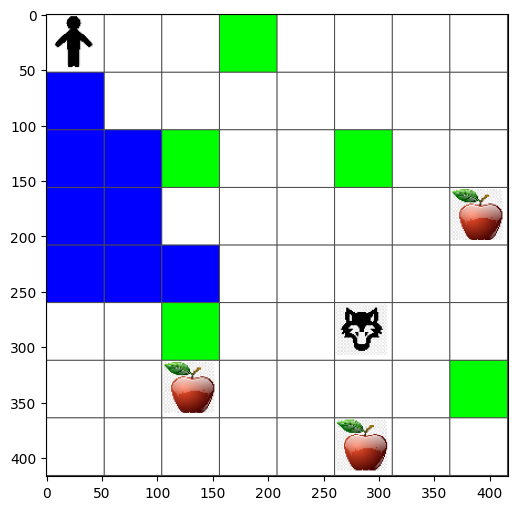

In [2]:
from rlboard import * #import rlboard.py

width, height = 8,8 #the width and height of the board
m = Board(width,height) #create the board
m.randomize(seed=2) #randomize the board
m.plot() #plot what the board looks like

In our example, Peter's goal would be able to find an apple, while avoiding the wolf and water. To do this, he can essentially walk around until he finds an apple. Therefore, at any position, he can choose between one of the following four actions:
- up
- down
- left
- right

We will define these actions as a dictionary and map them to pairs of corresponding coordinate changes. For example, moving right (`R`) would correspond to a pair `(1,0)`.

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) } #create a dictionary with the actions and their coordinate changes
action_idx = { a : i for i,a in enumerate(actions.keys()) } #create a dictionary with the action and their index
action_idx

{'U': 0, 'D': 1, 'L': 2, 'R': 3}

#### Random Walk Policy
One simple policy would be a 'random walk' strategy. This is a very simple strategy that does not use any reinforcement learning. For a random walk strategy, we will simply randomly choose the next action from the allowed actions until we reach the apple.

Implement the random walk with the below code. Note that in the `walk` function, the returned value will either be:
- -1 if the agent is eaten by the wolf, or 
- n, which is the number of steps taken to get to an apple.

In [8]:
def random_policy(m): #a policy which simply chooses an action with equal probability
    return random.choice(list(actions)) #a policy that will return a random choice

def walk(m,policy, start_position=None): #will play the game with map 'm', using the policy 'random_policy', with an optional start position defined
    n = 0 #will record the number of steps
    if start_position: #if a start position is defined
        m.human = start_position #set the start position
    else: #otherwise there is no start position defined
        m.random_start() #use random start position (empty white cell)
    while True: #play the game
        if m.at() == Board.Cell.apple: #if the agent is on an apple
            return n #return the number of steps to get to the apple (win)
        if m.at() == Board.Cell.wolf or m.at()==Board.Cell.water: #if the agent is on the wolf or water
            return -1 #eaten by wolf or drowned (lose)
        while True: #keep playing
            a = actions[policy(m)] #get a new action according to the policy
            new_pos = m.move_pos(m.human,a) #new potential position after making the action
            if m.is_valid(new_pos): #if the new position is valid (stay on board)
                m.move(a) # do the actual move
                break #keep playing
        n+=1 #increase the number of steps by 1

#call the walk function (play the game) with the map 'm', using the policy 'random_policy', with a random start position
walk(m,random_policy) #start in random empty location

4

The output will be the returned value from the `walk` function. It will output the length of the corresponding path taken to get to an apple, which can vary from one run to another. If it returns -1, then the agent was eaten by the wolf or drowned. Feel free to try re-running the code above multiple times. Due to randomness, your results will change!

A good policy would have the agent die a minimal number of times, while also finding the apple in a small amount of steps. It would be useful to run the experiment a number of times and calculate the average path length, along with the number of times the agent dies.

We can do this by using the code below, where we run the walk experiment a number of times (say, 100) and print the resulting statistics about the average path length and number of times eaten by the wolf:

In [12]:
def print_statistics(policy): #will print statistics about this policy
    #s will contain the total number of steps
    #w will contain the number of times the agent is eaten by the wolf
    #n will contain the number of times the apple is found
    s,w,n = 0,0,0
    for _ in range(100): #run 100 simulations
        z = walk(m,policy) #run the game and get the result
        if z<0: #agent was eaten by wolf
            w+=1 #increase w by 1
        else: #agent found the apple
            s += z #add the number of steps to the total number of steps
            n += 1 #increase n by 1
    print(f"Average path length = {s/n}, agent dies {w} times") #prints the average path length and number of times eaten by wolf

print_statistics(random_policy) #run the function above for the random_policy

Average path length = 16.20408163265306, agent dies 51 times


Note that the average length of a path when an apple is found is around 10 steps and the agent dies around 50% of the time. Let's try to do better than this with the help of a **reward function**!

#### A better policy using a Reward Function

To make our policy more intelligent, we need to understand which moves are "better" than others. To do this, we need to define our goal.

The goal can be defined in terms of a **reward function**, which will return some score value for each state of the game. The higher the number, the better the reward function. As the state of the game changes over time, the scores from the reward function can be added (for example) over time, to achieve some kind of final score.

The reward function coded below will reward +10 if the agent is on the apple, and the code will reward -10 if the agent is on water, the wolf, or an invalid location. Otherwise, the agent is on a safe space (white or green) and the reward will be -0.1.

In [27]:
goal_reward = 10 #the score for being on an apple
end_reward = -10 #the score for being eaten by a wolf or drowning (or outside of the board)
move_reward = -0.1 #the score for being on a safe space (white or green)

def reward(m): #given a state of the game (m), will return a score
    pos = m.human #position of the agent
    if not m.is_valid(pos): #if in an invalid position
        return end_reward
    x = m.at(pos) #location of the agent
    if x==Board.Cell.water or x == Board.Cell.wolf: #if agent is on water or the wolf
        return end_reward
    if x==Board.Cell.apple: #if the agent is on an apple
        return goal_reward
    return move_reward #otherwise the agent is on a "safe space" (white or green)

#### YOUR TURN

Why is a small negative reward (-0.1) provided if the agent is on a safe space (white or green)? 

<details>
  <summary>Click here for solution</summary>

The small negative reward punishes the agent for taking more steps before finding the apple. E.g., if the reward function scores are added up at the end of the game, finding an apple after 20 steps will result in a lower score (-0.1 x 20 + 10 = 8) than if an apple was found after 10 steps (-0.1 x 10 + 10 = 9). Also notice that finding the apple after 200 steps would reward the same score (-0.1 x 200 + 10= -10) as getting eaten by the wolf on step 1 (-10).
</details>

An interesting thing about reward functions is that in most cases, *we are only given a substantial reward at the end of the game*. This means that our algorithm should somehow remember "good" steps that lead to a positive reward at the end, and increase their importance. Similarly, all moves that lead to bad results should be discouraged.

### Q-Learning

An algorithm that we will discuss here is called **Q-Learning**. In this algorithm, the policy is defined by a function (or a data structure) called a **Q-Table**. It records the "goodness" of each of the actions in a given state.

It is called a Q-Table because it is often convenient to represent it as a table, or multi-dimensional array. Since our board has dimensions `width` x `height`, we can represent the Q-Table using a numpy array with shape `width` x `height` x `len(actions)`:

In [28]:
#a width x height x len(actions) array, filled with the value: 1/len(actions)
Q = np.ones((width,height,len(actions)),dtype=float)/len(actions)
Q.shape

(8, 8, 4)

Notice that we initialize all the values of the Q-Table with an equal value of 1/len(actions). Since we have 4 possible actions in this example, we have 1/len(actions) = 1/4 = 0.25. So this initially corresponds to the "random walk" policy, because all moves in each state are equally good. We can pass the Q-Table to the `plot` function in order to visualize the Q-Table on the board:

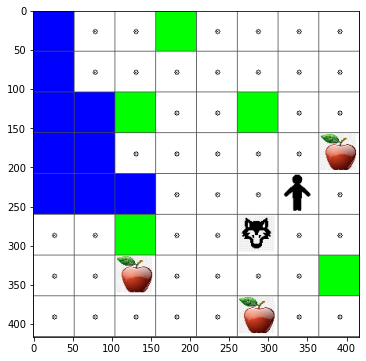

In [29]:
m.random_start() #use random start position (empty white cell)
m.plot(Q) #prints the board and the Q-Table

Using `m.plot(Q)`, in the center of each cell there will be an "arrow" that indicates the preferred direction of movement. But since all directions are equal right now, a dot is displayed.

Now we need to run the simulation, explore our environment, and learn a better distribution of Q-Table values, which will allow us to find the path to the apple much faster.

#### Essence of Q-Learning: Bellman Equation

When the agent is deciding an action, each potential action will have a corresponding reward. Therefore, a simple strategy to implement would be to select the next action based on the highest immediate reward. However, in most states, the move will not achieve our goal of reaching the apple, and thus we cannot immediately decide which direction is better. That is, in most cases, every action will move to a white or green location and thus have the same reward score.

> Remember that it is not the immediate result that matters, but rather the final result, which we will obtain at the end of the simulation.

In order to account for this delayed reward, we need to use the principles of **[dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming)**, which allow us to think about a problem recursively.

Suppose we are now at the state *s*, and we want to move to the next state *s'*. By doing so, we will receive the **immediate reward *r(s,a)***, defined by the reward function, plus some future reward. If we suppose that our Q-Table correctly reflects the "attractiveness" of each action, then at state *s'* we will chose an action *a'* that corresponds to the maximum value of *Q(s',a')*. Thus, the best possible future reward we could get at state *s* will be defined as `max`<sub>a'</sub>*Q(s',a')* (maximum here is computed over all possible actions *a'* at state *s'*).

This gives the **Bellman formula** for calculating the value of the Q-Table at state *s*, given action *a*:

$$
Q(s,a) = r(s,a) + \gamma \max_{a'} Q(s',a')
$$

Here $\gamma$ is the so-called "discount factor" that determines to which extent you should prefer the current reward over the future reward and vice versa. To summarize, the Q-Table score at state *s*, given action *a* $Q(s,a)$ is the immediate reward $r(s,a)$ plus the best possible future reward $\gamma \max_{a'} Q(s',a')$.

#### Learning Algorithm

Given the equation above, we can now write pseudo-code for our learning algorithm:

1. Initialize Q-Table Q with equal numbers for all states and actions
1. Set learning rate α ← 1
1. Repeat simulation many times:
   1. Start at random position
   1. Repeat:
        1. Select an action *a* at state *s*
        1. Execute action by moving to a new state *s'*
        1. If we encounter end-of-game condition, or total reward is too small - exit simulation  
        1. Compute reward *r* at the new state
        1. Update Q-Function according to Bellman equation: *Q(s,a)* ← *(1-α)Q(s,a)+α(r+γ max<sub>a'</sub>Q(s',a'))*
        1. *s* ← *s'*
        1. Update the total reward and decrease α.

#### Exploit vs. Explore

In the algorithm above, we did not specify how exactly we should choose an action at the beginning of the inner-most loop. If we are choosing the action randomly, we will randomly **explore** the environment, and we are quite likely to die often or explore areas where we would not normally go. An alternative approach would be to **exploit** the Q-Table values that we already know, and always choose the best immediate action (with higher Q-Table value) at state *s*. This, however, will likely prevent us from exploring rare states, and we might not find the optimal solution.

Therefore, the best approach is to strike a balance between exploration and exploitation. This can be done by choosing the action at state *s* with probabilities proportional to values in the Q-Table. In the beginning, when Q-Table values are all the same, it would correspond to a random selection, but as we learn more about our environment, we would be more likely to follow the optimal route, while also allowing the agent to choose the unexplored path occasionally.

#### Python Implementation

That was a lot of theory, but we are now ready to implement the learning algorithm above! By implementing the learning algorithm, we will essentially "train" the Q-Table to contain information about which action is optimal at any state of the game.

Lastly, before we do that, we will need some function that will convert arbitrary numbers in the Q-Table into a vector of probabilities for corresponding actions. To do this, we will create a function called `probs()`:

In [30]:
def probs(v,eps=1e-4): #will take a vector of arbitrary numbers are return a probability vector (values sum to 1)
    v = v-v.min()+eps #take each value in the vector and subtract it from the minimum (and add eps)
    v = v/v.sum() #then divide each value by the sum of the vector (so we have a set of probabilities that sum to 1)
    return v #return the probability vector

We add a small amount of `eps` to the original vector in order to avoid division by 0 in the initial case, when all components of the vector are identical.

Let's run the learning algorithm through 5000 experiments, also called **epochs**. We will keep track of when peter is eaten by the wolf, the number of steps taken when an apple is found, and the cumulative rewards score.

The code below may take a couple minutes to complete, so feel free to take a short break while it runs.

In [31]:
#reset Q-table
Q = np.ones((width,height,len(actions)),dtype=float)/len(actions)

died = [] #1 if died, 0 if not
steps_taken = [] #steps taken before apple is found
all_cum_rewards = [] #will record cumulative rewards score for each epoch

for epoch in range(50000):
    m.random_start() #use random start position (empty white cell)
    n=0 #will record the number of steps taken
    cum_reward = 0 #will record the cumulative reward
    while True:
        x,y = m.human #location of the agent
        v = probs(Q[x,y]) #probability vector from the Q-Table at this location
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        n+=1 #increase number of steps by 1
        r = reward(m) #the reward after the action
        cum_reward += r #add the reward to the cumulative reward
        if r==end_reward or cum_reward < -1000: #if dead (or invalid) OR agent has taken ALOT of steps without enough apples (cum_reward gets too small)
            died.append(1)
            all_cum_rewards.append(cum_reward)
            break #stop this run
        if r==goal_reward: #apple is found
            died.append(0)
            steps_taken.append(n) #record the length of this path
            all_cum_rewards.append(cum_reward)
            break #stop this run
        alpha = np.exp(-n / 10e5) #set alpha value
        gamma = 0.5 #set gamma value
        ai = action_idx[a] #the action index {'U': 0, 'D': 1, 'L': 2, 'R': 3}
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max()) #update Q-Table according to Bellman formula
    

After the above code completes, the Q-Table should be updated with values that define the attractiveness of different actions at each step. Great work! We can try to visualize the Q-Table by plotting a vector at each cell that will point in the desired direction of movement. For simplicity, we draw a small circle instead of an arrow head:

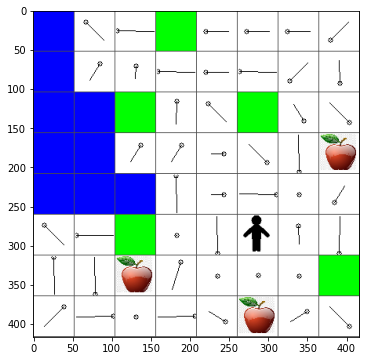

In [32]:
m.plot(Q) #prints the board and the Q-Table

We can also examine the learning process by examining how the number of steps to find an apple changed as agent learned.

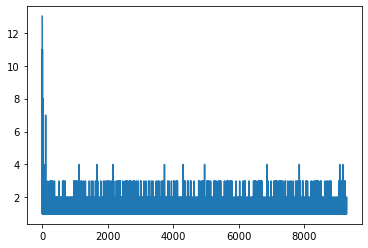

In [33]:
plt.plot(steps_taken)

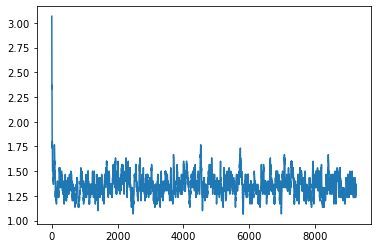

In [34]:
def running_average(x,window):
    return np.convolve(x,np.ones(window)/window,mode='valid')

plt.plot(running_average(steps_taken,30))

#### A Better Policy

Now that we have a trained Q-Table, we can use it to define a better navigation policy than the random walk we implemented at the beginning of this lesson. In this policy, we will combine exploitation and exploration to select each action with a certain probability, proportional to the values in the Q-Table. This strategy may still result in the agent returning back to a position it has already explored, but, as you can see from the code below, it results in a much shorter average path to finding its first apple (remember that `print_statistics` runs the simulation 100 times).

In [35]:
def qpolicy(m): #policy that uses the Q-Table
        x,y = m.human #position of the agent
        v = probs(Q[x,y]) #vector of probabilities from the Q-Table
        a = random.choices(list(actions),weights=v)[0] #choose the action based on the vector of probabilities
        return a #return the chosen action

print_statistics(qpolicy) #this will run the walk function 100 times with the policy that utilizes the trained Q-Table

print_statistics(random_policy) #this will run the walk function 100 times with random walk policy

Average path length = 4.188679245283019, agent dies 47 times
Average path length = 8.633333333333333, agent dies 70 times


After running both policies, you can see that the policy that utilizes the trained Q-Table results in a much smaller average path length to find an apple than the random walk policy!

### A Reinforcement Learning Example
http://projects.rajivshah.com/rldemo/

- epsilon: randomness of agent
- gamma: how far in the future the agent is looking


### OpenAI Gym (now Gymnasium)

https://github.com/openai/gym

https://github.com/microsoft/ML-For-Beginners/tree/main/8-Reinforcement/2-Gym